In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, neighbors, ensemble, svm, metrics
from imblearn.under_sampling import CondensedNearestNeighbour
import copy

### Составляем различные таблицы

In [36]:
dau = pd.read_csv('practice_dau_and.csv', sep='|')
pact = pd.read_csv('practice_pact_and.csv', sep='|')
print('Loaded')

Loaded


Таблица "платящих" игроков:

In [38]:
pay_players = pact[pact.transactions > 0].reset_index()
pay_players = pay_players.drop(['index'], axis='columns')
pay_players.to_csv('pay_players_pact.csv', sep='|')
pay_players = pay_players.groupby(['id'], as_index=False).count()
pay_players = pay_players.drop(['actdate', 'regdate', 'clusters', 
                                'revenue', 'transactions', 'quest',
                                'm_quests', 'crystals', 'store_enters'], axis='columns')
#print(pay_players)
pay_players.to_csv('pay_players.csv')

In [39]:
dau2 = pd.merge(pay_players, dau, on=['id'], how='left')
dau_pact = pd.merge(dau2, pact, on=['id', 'actdate'], how='left')
#print(dau_pact)
dau_pact.to_csv('pay_players_dau_pact.csv')

Таблица активных игроков:

In [ ]:
pact['day_n'] = (pd.to_datetime(pact['actdate']) - 
                 pd.to_datetime(pact['regdate'])).dt.days
active_players = pact[pact.day_n < 31 + 14].reset_index()
active_players = active_players[pd.to_datetime(active_players.regdate) < pd.to_datetime('2017-04-15')].reset_index()
active_players = active_players.pivot_table(values='actdate', columns=['day_n'], index=['id'], aggfunc='count')
active_players['w3_played'] = active_players[[17.0, 18, 19, 20, 21, 22, 23]].count(1)
active_players['w4_played'] = active_players[[24.0, 25, 26, 27, 28, 29, 30]].count(1)
active_players = active_players[active_players['w3_played'] + active_players['w4_played'] > 0]
active_players = active_players.reset_index()['id']
active_players = pd.DataFrame({'id': active_players})
active_players.to_csv('active_players.csv')

In [ ]:
dau2 = pd.merge(active_players, dau, on=['id'], how='left')
dau_pact = pd.merge(dau2, pact, on=['id', 'actdate'], how='left')
dau_pact.drop('day_n', axis='columns').to_csv('active_players_dau_pact.csv')

#### График, показывающий активность игрока

In [41]:
def show_player_pgr(player_id, days=31):
    player_table = pd.DataFrame({'id': [player_id]})
    res = pd.merge(player_table, dau_pact, on=['id'], how='left')
    #print(res)
    res = res.drop(['crystals', 'store_enters', 'm_quests', 'quest', 
                    'revenue', 'transactions', 'country', 'clusters'], axis='columns')
    res = res.groupby(['actdate'], as_index=False).sum()
    res = res.set_index('actdate')
    res = res.sort_index(0)
    res = res.reset_index()
    #print(res)
    first_day = res['actdate'][0]
    m_later_day = pd.date_range(first_day, periods=days, freq='D').date[-1]
    #print(first_day, str(m_later_day))
    new_sample_df = res.set_index('actdate').loc[first_day:str(m_later_day)]
    new_sample_df.plot()
    plt.show()

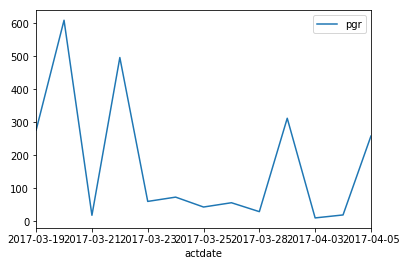

In [45]:
show_player_pgr('fd623cb00f')

Ниже приведен код для получения таблицы с бинарно закодированной принадлежностью игрока стране.

ВАЖНО: код не оптимизирован и использует циклы для прохода по таблице. Для хорошей работы рекомендуется переписать его по-нормальному.

In [16]:
country_feature = (pd.read_csv('pay_players_dau_pact.csv').drop('Unnamed: 0', axis='columns').set_index('id')['country']).reset_index()
map_country = dict()
for i in range(len(country_feature['id'])):
    map_country[country_feature['id'][i]] = country_feature['country'][i]
country_array = []
id_array = []
for _id in map_country:
    id_array.append(_id)
    country_array.append(map_country[_id])
country_feature = pd.get_dummies(pd.DataFrame({'id': id_array, 'country': country_array}).set_index('id')['country']).reset_index()

In [50]:
print(country_feature)
print(country_feature.columns)

               id  --  AE  AM  AR  AT  AU  AW  AZ  BA ...  TT  TW  TZ  UA  US  \
0      8657fd9864   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
1      384332f747   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
2      22139ab537   0   1   0   0   0   0   0   0   0 ...   0   0   0   0   0   
3      6235e3e291   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   
4      2222236ac7   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
5      a3edc8f3c3   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
6      5aa4215ec4   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
7      e990bd8e89   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
8      3da00c9d73   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
9      5bf13afc59   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
10     4b497cbb05   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   
11     11420820a9   0   0   

Таблица с данными о сессиях (приведен код для "платящих" игроков; код для активных игроков можно получить заменой названия файла pay_players.csv на active_players.csv):

In [ ]:
pact = pd.read_csv('practice_pact_and.csv', sep='|')
players_regdates = pd.DataFrame({'id': pact['id'], 'regdate': pact['regdate']}).drop_duplicates().reset_index().drop('index', axis='columns')
pay_players = pd.read_csv('active_players.csv').drop('Unnamed: 0', axis='columns')
del pact
players_regdates = pd.merge(players_regdates, pay_players, on='id', how='inner')
del pay_players
sessions = pd.read_csv('practice_sessions_and.csv', sep='|')
pay_players_sessions = pd.merge(players_regdates, sessions, on='id', how='inner').drop(['session_number'], axis='columns')
pay_players_sessions['day_n'] = (pd.to_datetime(pay_players_sessions['actdate']) - 
                           pd.to_datetime(pay_players_sessions['regdate'])).dt.days
pay_players_sessions = pay_players_sessions[pay_players_sessions.day_n < 31 + 14]
pay_players_sessions = pay_players_sessions[pay_players_sessions.day_n >= 0]
pay_players_sessions = pay_players_sessions[pd.to_datetime(pay_players_sessions.regdate) < pd.to_datetime('2017-04-15')]
pay_players_sessions.to_csv('active_players_sessions.csv', index=False)

# Составляем сводную таблицу

Ниже приведен пример для таблицы активных игроков. Для того, чтобы сделать таблицу платящих игроков, достаточно заменить названия файлов active_players_dau_pact.csv на pay_players_dau_pact.csv; active_players_sessions.csv на pay_players_sessions.csv.

In [21]:
dau_pact = pd.read_csv('active_players_dau_pact.csv').drop('Unnamed: 0', axis='columns')
dau_pact_table = dau_pact.drop(['clusters', 'revenue', 'quest', 
                          'm_quests', 'crystals', 'store_enters', 
                          'transactions', 'country'], axis='columns')
dau_pact_table['day_n'] = (pd.to_datetime(dau_pact_table['actdate']) - 
                           pd.to_datetime(dau_pact_table['regdate'])).dt.days
dau_pact_table = dau_pact_table[dau_pact_table.day_n < 31 + 14].reset_index()
dau_pact_table = dau_pact_table[pd.to_datetime(dau_pact_table.regdate) < pd.to_datetime('2017-04-15')].reset_index()
dau_pact_table = dau_pact_table.pivot_table(values='pgr', columns=['day_n'], index=['id'], aggfunc='sum')
del dau_pact

Составляем таблицу фич:

In [56]:
dau_pact_features = pd.read_csv('active_players_dau_pact.csv').drop('Unnamed: 0', axis='columns')
features = ['pgr', 'clusters', 'quest', 'm_quests']
dau_pact_features['day_n'] = (pd.to_datetime(dau_pact_features['actdate']) - 
                           pd.to_datetime(dau_pact_features['regdate'])).dt.days
dau_pact_features = dau_pact_features[dau_pact_features.day_n < 31 + 14]
dau_pact_features = dau_pact_features[pd.to_datetime(dau_pact_features.regdate) < pd.to_datetime('2017-04-15')]
feature_table = pd.DataFrame(dau_pact_features['id'].drop_duplicates())
clf_features = []
for feat in features:
    dau_pact_features_tmp = dau_pact_features.pivot_table(values=feat, columns=['day_n'], index=['id'], aggfunc='sum')
    dau_pact_features_tmp[feat+'_w1_mean'] = dau_pact_features_tmp[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).mean(1)
    dau_pact_features_tmp[feat+'_w2_mean'] = dau_pact_features_tmp[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).mean(1)
    dau_pact_features_tmp[feat+'_w3_mean'] = dau_pact_features_tmp[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).mean(1)
    dau_pact_features_tmp[feat+'_w4_mean'] = dau_pact_features_tmp[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).mean(1)
    dau_pact_features_tmp[feat+'_w1_max'] = dau_pact_features_tmp[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).max(1)
    dau_pact_features_tmp[feat+'_w2_max'] = dau_pact_features_tmp[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).max(1)
    dau_pact_features_tmp[feat+'_w3_max'] = dau_pact_features_tmp[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).max(1)
    dau_pact_features_tmp[feat+'_w4_max'] = dau_pact_features_tmp[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).max(1)
    dau_pact_features_tmp[feat+'_w1_meandmax'] = (dau_pact_features_tmp[feat+'_w1_mean'] / dau_pact_features_tmp[feat+'_w1_max']).replace('NaN', 0)
    dau_pact_features_tmp[feat+'_w2_meandmax'] = (dau_pact_features_tmp[feat+'_w2_mean'] / dau_pact_features_tmp[feat+'_w2_max']).replace('NaN', 0)
    dau_pact_features_tmp[feat+'_w3_meandmax'] = (dau_pact_features_tmp[feat+'_w3_mean'] / dau_pact_features_tmp[feat+'_w3_max']).replace('NaN', 0)
    dau_pact_features_tmp[feat+'_w4_meandmax'] = (dau_pact_features_tmp[feat+'_w4_mean'] / dau_pact_features_tmp[feat+'_w4_max']).replace('NaN', 0)
    #dau_pact_features_tmp[feat+'_w1_av_deviat'] = (dau_pact_features_tmp[feat+'_w1_mean'] - dau_pact_features_tmp[3.0]).abs()
    #for i in [4.0, 5.0, 6.0, 7.0, 8.0, 9.0]:
    #    dau_pact_features_tmp[feat+'_w1_av_deviat'] += (dau_pact_features_tmp[feat+'_w1_mean'] - dau_pact_features_tmp[i]).abs()
    #dau_pact_features_tmp[feat+'_w1_av_deviat'] /= 7
    #dau_pact_features_tmp[feat+'_w2_av_deviat'] = (dau_pact_features_tmp[feat+'_w2_mean'] - dau_pact_features_tmp[10.0]).abs()
    #for i in [11.0, 12.0, 13.0, 14.0, 15.0, 16.0]:
    #    dau_pact_features_tmp[feat+'_w2_av_deviat'] += (dau_pact_features_tmp[feat+'_w2_mean'] - dau_pact_features_tmp[i]).abs()
    #dau_pact_features_tmp[feat+'_w2_av_deviat'] /= 7
    #dau_pact_features_tmp[feat+'_w3_av_deviat'] = (dau_pact_features_tmp[feat+'_w3_mean'] - dau_pact_features_tmp[17.0]).abs()
    #for i in [18.0, 19.0, 20.0, 21.0, 22.0, 23.0]:
    #    dau_pact_features_tmp[feat+'_w3_av_deviat'] += (dau_pact_features_tmp[feat+'_w3_mean'] - dau_pact_features_tmp[i]).abs()
    #dau_pact_features_tmp[feat+'_w3_av_deviat'] /= 7
    #dau_pact_features_tmp[feat+'_w4_av_deviat'] = (dau_pact_features_tmp[feat+'_w4_mean'] - dau_pact_features_tmp[24.0]).abs()
    #for i in [25.0, 26.0, 27.0, 28.0, 29.0, 30.0]:
    #    dau_pact_features_tmp[feat+'_w4_av_deviat'] += (dau_pact_features_tmp[feat+'_w4_mean'] - dau_pact_features_tmp[i]).abs()
    #dau_pact_features_tmp[feat+'_w4_av_deviat'] /= 7
    #for col in dau_pact_features_tmp.columns[:-4]:
    #    if col >= 3.0 and col <= 30.0:
    #        clf_features.append(feat+'_'+str(col))
    #    dau_pact_features_tmp.rename(columns={col: feat+'_'+str(col)}, inplace=True)
    dau_pact_features_tmp = dau_pact_features_tmp.reset_index()
    #print(dau_pact_features_tmp[feat+'_w1_mean'])
    
    #print(pd.DataFrame({'id': dau_pact_features_tmp['id'],
    #                                                      feat+'_w1_mean': dau_pact_features_tmp[feat+'_w1_mean'],
    #                                                      feat+'_w2_mean': dau_pact_features_tmp[feat+'_w2_mean'],
    #                                                      feat+'_w3_mean': dau_pact_features_tmp[feat+'_w3_mean'],
    #                                                      feat+'_w4_mean': dau_pact_features_tmp[feat+'_w4_mean']}))
    #print(feature_table)
    feature_table = pd.merge(feature_table, pd.DataFrame({'id': dau_pact_features_tmp['id'],
                                                          feat+'_w1_mean': dau_pact_features_tmp[feat+'_w1_mean'],
                                                          feat+'_w2_mean': dau_pact_features_tmp[feat+'_w2_mean'],
                                                          feat+'_w3_mean': dau_pact_features_tmp[feat+'_w3_mean'],
                                                          feat+'_w4_mean': dau_pact_features_tmp[feat+'_w4_mean'],
                                                          #feat+'_w1_max': dau_pact_features_tmp[feat+'_w1_max'],
                                                          #feat+'_w2_max': dau_pact_features_tmp[feat+'_w2_max'],
                                                          #feat+'_w3_max': dau_pact_features_tmp[feat+'_w3_max'],
                                                          #feat+'_w4_max': dau_pact_features_tmp[feat+'_w4_max'],
                                                          feat+'_w1_meandmax': dau_pact_features_tmp[feat+'_w1_meandmax'],
                                                          feat+'_w2_meandmax': dau_pact_features_tmp[feat+'_w2_meandmax'],
                                                          feat+'_w3_meandmax': dau_pact_features_tmp[feat+'_w3_meandmax'],
                                                          feat+'_w4_meandmax': dau_pact_features_tmp[feat+'_w4_meandmax'],
                                                          #feat+'_w1_av_deviat': dau_pact_features_tmp[feat+'_w1_av_deviat'],
                                                          #feat+'_w2_av_deviat': dau_pact_features_tmp[feat+'_w2_av_deviat'],
                                                          #feat+'_w3_av_deviat': dau_pact_features_tmp[feat+'_w3_av_deviat'],
                                                          #feat+'_w4_av_deviat': dau_pact_features_tmp[feat+'_w4_av_deviat']
                                                         }), 
                             how='inner', on=['id'])
    clf_features += [feat+'_w1_mean',
                     feat+'_w2_mean',
                     feat+'_w3_mean',
                     feat+'_w4_mean',
                     #feat+'_w1_max',
                     #feat+'_w2_max',
                     #feat+'_w3_max',
                     #feat+'_w4_max',
                     feat+'_w1_meandmax',
                     feat+'_w2_meandmax',
                     feat+'_w3_meandmax',
                     feat+'_w4_meandmax'#,
                     #feat+'_w1_av_deviat',
                     #feat+'_w2_av_deviat',
                     #feat+'_w3_av_deviat',
                     #feat+'_w4_av_deviat'
                    ]
    print(feat + ': done')
    #feature_table = pd.merge(feature_table, dau_pact_features_tmp, on='id', how='inner')
    #print(feature_table)
    #print(pd.DataFrame([dau_pact_features_tmp['id'],
    #                                                  dau_pact_features_tmp[feat+'_w1_mean'],
    #                                                  dau_pact_features_tmp[feat+'_w2_mean'],
    #                                                  dau_pact_features_tmp[feat+'_w3_mean'],
    #                                                  dau_pact_features_tmp[feat+'_w4_mean']]))
    #print(dau_pact_features)

pgr: done
clusters: done
quest: done
m_quests: done


В клетке ниже можно с нуля построить массив фич (вспомогательная клетка):

In [4]:
features = ['pgr', 'clusters', 'quest', 'm_quests', 'transactions', 'revenue']
clf_features = []
for feat in features:
    clf_features += [feat+'_w1_mean',
                     feat+'_w2_mean',
                     feat+'_w3_mean',
                     feat+'_w4_mean',
                     #feat+'_w1_max',
                     #feat+'_w2_max',
                     #feat+'_w3_max',
                     #feat+'_w4_max',
                     feat+'_w1_meandmax',
                     feat+'_w2_meandmax',
                     feat+'_w3_meandmax',
                     feat+'_w4_meandmax',
                     feat+'_w1_av_deviat',
                     feat+'_w2_av_deviat',
                     feat+'_w3_av_deviat',
                     feat+'_w4_av_deviat'
                    ]

Сохраняем таблицу фич:

In [23]:
#print(feature_table)
#print(feature_table.columns)
feature_table.to_csv('feature_table.csv', index=False)

In [24]:
feature_table = pd.read_csv('feature_table.csv')

Объединяем заготовку сводной таблицы и таблицу фич:

In [25]:
dau_pact_table = pd.merge(dau_pact_table.reset_index(), feature_table, on='id', how='inner')
dau_pact_table.set_index('id', inplace=True)

Дополнительные фичи и столбцы:

In [26]:
dau_pact_table['m_played'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9, 
                      10, 11, 12, 13, 14, 15, 16,
                      17, 18, 19, 20, 21, 22, 23, 
                      24, 25, 26, 27, 28, 29, 30]].count(1)
dau_pact_table['w1_played'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9]].count(1)
dau_pact_table['w2_played'] = dau_pact_table[[10.0, 11, 12, 13, 14, 15, 16]].count(1)
dau_pact_table['w3_played'] = dau_pact_table[[17.0, 18, 19, 20, 21, 22, 23]].count(1)
dau_pact_table['w4_played'] = dau_pact_table[[24.0, 25, 26, 27, 28, 29, 30]].count(1)
dau_pact_table['result_played'] = dau_pact_table[[31.0, 32, 33, 34, 35, 36, 37,
                                                  38, 39, 40, 41, 42, 43, 44]].count(1)
dau_pact_table['is_active'] = (dau_pact_table['result_played'] > 0) * 1
dau_pact_table['result_category'] = (dau_pact_table['result_played'] / 4).round()
clf_features += ['w1_played', 'w2_played', 'w3_played', 'w4_played']
dau_pact_table = dau_pact_table.drop([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 
                     10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 
                     17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0,
                     24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0,
                     31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0,
                     38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0], axis='columns')

Составляем сводные таблицы на основе данных 3-й таблицы:

In [27]:
players_sessions = pd.read_csv('active_players_sessions.csv')
sum_len_sess = players_sessions.pivot_table(values='session_length', columns=['day_n'], index=['id'], aggfunc='sum')
n_sess = players_sessions.pivot_table(values='session_length', columns=['day_n'], index=['id'], aggfunc='count')

In [28]:
n_sess['sess_w1_mean'] = n_sess[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).mean(1)
n_sess['sess_w2_mean'] = n_sess[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).mean(1)
n_sess['sess_w3_mean'] = n_sess[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).mean(1)
n_sess['sess_w4_mean'] = n_sess[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).mean(1)
n_sess['sess_w1_max'] = n_sess[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).max(1)
n_sess['sess_w2_max'] = n_sess[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).max(1)
n_sess['sess_w3_max'] = n_sess[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).max(1)
n_sess['sess_w4_max'] = n_sess[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).max(1)
n_sess['sess_w1_meandmax'] = n_sess['sess_w1_mean'] / n_sess['sess_w1_max']
n_sess['sess_w2_meandmax'] = n_sess['sess_w2_mean'] / n_sess['sess_w2_max']
n_sess['sess_w3_meandmax'] = n_sess['sess_w3_mean'] / n_sess['sess_w3_max']
n_sess['sess_w4_meandmax'] = n_sess['sess_w4_mean'] / n_sess['sess_w4_max']
#n_sess['sess_w1_av_deviat'] = (n_sess['sess_w1_mean'] - n_sess[3.0]).abs()
#for i in [4.0, 5.0, 6.0, 7.0, 8.0, 9.0]:
#    n_sess['sess_w1_av_deviat'] += (n_sess['sess_w1_mean'] - n_sess[i]).abs()
#n_sess['sess_w1_av_deviat'] /= 7
#n_sess['sess_w2_av_deviat'] = (n_sess['sess_w2_mean'] - n_sess[10.0]).abs()
#for i in [11.0, 12.0, 13.0, 14.0, 15.0, 16.0]:
#    n_sess['sess_w2_av_deviat'] += (n_sess['sess_w2_mean'] - n_sess[i]).abs()
#n_sess['sess_w2_av_deviat'] /= 7
#n_sess['sess_w3_av_deviat'] = (n_sess['sess_w3_mean'] - n_sess[17.0]).abs()
#for i in [18.0, 19.0, 20.0, 21.0, 22.0, 23.0]:
#    n_sess['sess_w3_av_deviat'] += (n_sess['sess_w3_mean'] - n_sess[i]).abs()
#n_sess['sess_w3_av_deviat'] /= 7
#n_sess['sess_w4_av_deviat'] = (n_sess['sess_w4_mean'] - n_sess[24.0]).abs()
#for i in [25.0, 26.0, 27.0, 28.0, 29.0, 30.0]:
#    n_sess['sess_w4_av_deviat'] += (n_sess['sess_w4_mean'] - n_sess[i]).abs()
#n_sess['sess_w4_av_deviat'] /= 7
clf_features += ['sess_w1_mean',
                 'sess_w2_mean',
                 'sess_w3_mean',
                 'sess_w4_mean',
                 #'sess_w1_max',
                 #'sess_w2_max',
                 #'sess_w3_max',
                 #'sess_w4_max',
                 'sess_w1_meandmax',
                 'sess_w2_meandmax',
                 'sess_w3_meandmax',
                 'sess_w4_meandmax'#,
                 #'sess_w1_av_deviat',
                 #'sess_w2_av_deviat',
                 #'sess_w3_av_deviat',
                 #'sess_w4_av_deviat'
                ]
n_sess.reset_index(inplace=True)
sum_len_sess['lensess_w1_mean'] = sum_len_sess[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).mean(1)
sum_len_sess['lensess_w2_mean'] = sum_len_sess[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).mean(1)
sum_len_sess['lensess_w3_mean'] = sum_len_sess[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).mean(1)
sum_len_sess['lensess_w4_mean'] = sum_len_sess[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).mean(1)
sum_len_sess['lensess_w1_max'] = sum_len_sess[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).max(1)
sum_len_sess['lensess_w2_max'] = sum_len_sess[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).max(1)
sum_len_sess['lensess_w3_max'] = sum_len_sess[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).max(1)
sum_len_sess['lensess_w4_max'] = sum_len_sess[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).max(1)
sum_len_sess['lensess_w1_meandmax'] = sum_len_sess['lensess_w1_mean'] / sum_len_sess['lensess_w1_max']
sum_len_sess['lensess_w2_meandmax'] = sum_len_sess['lensess_w2_mean'] / sum_len_sess['lensess_w2_max']
sum_len_sess['lensess_w3_meandmax'] = sum_len_sess['lensess_w3_mean'] / sum_len_sess['lensess_w3_max']
sum_len_sess['lensess_w4_meandmax'] = sum_len_sess['lensess_w4_mean'] / sum_len_sess['lensess_w4_max']
#sum_len_sess['lensess_w1_av_deviat'] = (sum_len_sess['lensess_w1_mean'] - sum_len_sess[3.0]).abs()
#for i in [4.0, 5.0, 6.0, 7.0, 8.0, 9.0]:
#    sum_len_sess['lensess_w1_av_deviat'] += (sum_len_sess['lensess_w1_mean'] - sum_len_sess[i]).abs()
#sum_len_sess['lensess_w1_av_deviat'] /= 7
#sum_len_sess['lensess_w2_av_deviat'] = (sum_len_sess['lensess_w2_mean'] - sum_len_sess[10.0]).abs()
#for i in [11.0, 12.0, 13.0, 14.0, 15.0, 16.0]:
#    sum_len_sess['lensess_w2_av_deviat'] += (sum_len_sess['lensess_w2_mean'] - sum_len_sess[i]).abs()
#sum_len_sess['lensess_w2_av_deviat'] /= 7
#sum_len_sess['lensess_w3_av_deviat'] = (sum_len_sess['lensess_w3_mean'] - sum_len_sess[17.0]).abs()
#for i in [18.0, 19.0, 20.0, 21.0, 22.0, 23.0]:
#    sum_len_sess['lensess_w3_av_deviat'] += (sum_len_sess['lensess_w3_mean'] - sum_len_sess[i]).abs()
#sum_len_sess['lensess_w3_av_deviat'] /= 7
#sum_len_sess['lensess_w4_av_deviat'] = (sum_len_sess['lensess_w4_mean'] - sum_len_sess[24.0]).abs()
#for i in [25.0, 26.0, 27.0, 28.0, 29.0, 30.0]:
#    sum_len_sess['lensess_w4_av_deviat'] += (sum_len_sess['lensess_w4_mean'] - sum_len_sess[i]).abs()
#sum_len_sess['lensess_w4_av_deviat'] /= 7
sum_len_sess.reset_index(inplace=True)
sess_features = pd.DataFrame({'id': n_sess['id'],
                              'sess_w1_mean': n_sess['sess_w1_mean'],
                              'sess_w2_mean': n_sess['sess_w2_mean'],
                              'sess_w3_mean': n_sess['sess_w3_mean'],
                              'sess_w4_mean': n_sess['sess_w4_mean'],
                              #'sess_w1_max': n_sess['sess_w1_max'],
                              #'sess_w2_max': n_sess['sess_w2_max'],
                              #'sess_w3_max': n_sess['sess_w3_max'],
                              #'sess_w4_max': n_sess['sess_w4_max'],
                              'sess_w1_meandmax': n_sess['sess_w1_meandmax'],
                              'sess_w2_meandmax': n_sess['sess_w2_meandmax'],
                              'sess_w3_meandmax': n_sess['sess_w3_meandmax'],
                              'sess_w4_meandmax': n_sess['sess_w4_meandmax']#,
                              #'sess_w1_av_deviat': n_sess['sess_w1_av_deviat'],
                              #'sess_w2_av_deviat': n_sess['sess_w2_av_deviat'],
                              #'sess_w3_av_deviat': n_sess['sess_w3_av_deviat'],
                              #'sess_w4_av_deviat': n_sess['sess_w4_av_deviat']
                             })
sess_features = pd.merge(sess_features, pd.DataFrame({'id': sum_len_sess['id'],
                              'lensess_w1_mean': sum_len_sess['lensess_w1_mean'],
                              'lensess_w2_mean': sum_len_sess['lensess_w2_mean'],
                              'lensess_w3_mean': sum_len_sess['lensess_w3_mean'],
                              'lensess_w4_mean': sum_len_sess['lensess_w4_mean'],
                              #'lensess_w1_max': sum_len_sess['lensess_w1_max'],
                              #'lensess_w2_max': sum_len_sess['lensess_w2_max'],
                              #'lensess_w3_max': sum_len_sess['lensess_w3_max'],
                              #'lensess_w4_max': sum_len_sess['lensess_w4_max'],
                              'lensess_w1_meandmax': sum_len_sess['lensess_w1_meandmax'],
                              'lensess_w2_meandmax': sum_len_sess['lensess_w2_meandmax'],
                              'lensess_w3_meandmax': sum_len_sess['lensess_w3_meandmax'],
                              'lensess_w4_meandmax': sum_len_sess['lensess_w4_meandmax']#,
                              #'lensess_w1_av_deviat': sum_len_sess['lensess_w1_av_deviat'],
                              #'lensess_w2_av_deviat': sum_len_sess['lensess_w2_av_deviat'],
                              #'lensess_w3_av_deviat': sum_len_sess['lensess_w3_av_deviat'],
                              #'lensess_w4_av_deviat': sum_len_sess['lensess_w4_av_deviat']
                                                     }),
                        how='inner', on='id')
clf_features += ['lensess_w1_mean',
                 'lensess_w2_mean',
                 'lensess_w3_mean',
                 'lensess_w4_mean',
                 #'lensess_w1_max',
                 #'lensess_w2_max',
                 #'lensess_w3_max',
                 #'lensess_w4_max',
                 'lensess_w1_meandmax',
                 'lensess_w2_meandmax',
                 'lensess_w3_meandmax',
                 'lensess_w4_meandmax'#,
                 #'lensess_w1_av_deviat',
                 #'lensess_w2_av_deviat',
                 #'lensess_w3_av_deviat',
                 #'lensess_w4_av_deviat'
                ]

In [29]:
dau_pact_table = pd.merge(dau_pact_table.reset_index(), sess_features, on='id', how='inner')

Cписок фич, которые мы будем использовать для обучения:

In [30]:
print(clf_features)

['pgr_w1_mean', 'pgr_w2_mean', 'pgr_w3_mean', 'pgr_w4_mean', 'pgr_w1_meandmax', 'pgr_w2_meandmax', 'pgr_w3_meandmax', 'pgr_w4_meandmax', 'clusters_w1_mean', 'clusters_w2_mean', 'clusters_w3_mean', 'clusters_w4_mean', 'clusters_w1_meandmax', 'clusters_w2_meandmax', 'clusters_w3_meandmax', 'clusters_w4_meandmax', 'quest_w1_mean', 'quest_w2_mean', 'quest_w3_mean', 'quest_w4_mean', 'quest_w1_meandmax', 'quest_w2_meandmax', 'quest_w3_meandmax', 'quest_w4_meandmax', 'm_quests_w1_mean', 'm_quests_w2_mean', 'm_quests_w3_mean', 'm_quests_w4_mean', 'm_quests_w1_meandmax', 'm_quests_w2_meandmax', 'm_quests_w3_meandmax', 'm_quests_w4_meandmax', 'w1_played', 'w2_played', 'w3_played', 'w4_played', 'sess_w1_mean', 'sess_w2_mean', 'sess_w3_mean', 'sess_w4_mean', 'sess_w1_meandmax', 'sess_w2_meandmax', 'sess_w3_meandmax', 'sess_w4_meandmax', 'lensess_w1_mean', 'lensess_w2_mean', 'lensess_w3_mean', 'lensess_w4_mean', 'lensess_w1_meandmax', 'lensess_w2_meandmax', 'lensess_w3_meandmax', 'lensess_w4_meandm

#### Регрессия:

In [53]:
threshold = 36000
CLF_THRESHOLD = 0.5

dau_pact_table.fillna(0, inplace=True)
dau_pact_table.replace(np.inf, 0, inplace=True)
dau_pact_table.replace(-np.inf, 0, inplace=True)
dau_pact_table.reset_index(inplace=True)

train_input_clf = dau_pact_table[:threshold].as_matrix(columns=clf_features)
train_output_clf = np.array(dau_pact_table['is_active'][:threshold].tolist())

fitted_clf_gbr = ensemble.GradientBoostingRegressor(subsample=0.7, loss='ls').fit(train_input_clf, train_output_clf)
dau_pact_table['predict_active'] = (fitted_clf_gbr.predict(dau_pact_table.as_matrix(
                                                            columns=clf_features)) > CLF_THRESHOLD) * 1
train_input_prd = dau_pact_table[:threshold][dau_pact_table['is_active'] == 1].as_matrix(columns=clf_features)
train_output_prd = np.array(dau_pact_table[:threshold][dau_pact_table['is_active'] == 1]['result_played'].tolist())

fitted_prd_etr = ensemble.ExtraTreesRegressor(n_estimators=100).fit(train_input_prd, train_output_prd)
dau_pact_table['predict_days'] = fitted_prd_etr.predict(dau_pact_table.as_matrix(columns=clf_features))

#dau_pact_table['predict_active'] = dau_pact_table['predict_active'] * (dau_pact_table['predict_days'] > 0)

dau_pact_table.set_index('id', inplace=True)

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


#### Результаты:

In [54]:
dau_pact_table['clf_acc'] = (dau_pact_table['is_active'] == dau_pact_table['predict_active']) * 1
dau_pact_table['clf_e1'] = (dau_pact_table['is_active'] > dau_pact_table['predict_active']) * 1
dau_pact_table['clf_e2'] = (dau_pact_table['is_active'] < dau_pact_table['predict_active']) * 1
dau_pact_table['prd_delta'] = ((dau_pact_table['result_played'] - dau_pact_table['predict_days']).abs())
dau_pact_table['overall_delta'] = ((dau_pact_table['result_played'] * dau_pact_table['is_active'] - dau_pact_table['predict_days'] * dau_pact_table['predict_active']).abs())

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Среднее отклонение классификатора активности: 0.187707725271
Ошибка классификатора 1 рода (игрок на самом деле активен): 0.109881396251
Ошибка классификатора 2 рода (игрок на самом деле неактивен): 0.07782632902
Среднее отклонение предсказателя дней: 2.74061981446
Среднее общее отклонение: 1.93253943617
[45084, 15278, 5750, 1164, 108]
[19267, 12730, 3291, 466, 62]


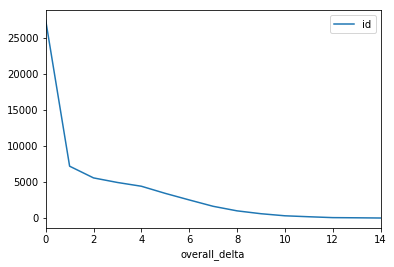

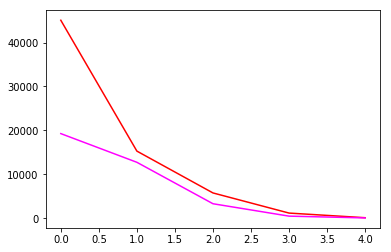

In [55]:
prd_delta = dau_pact_table[threshold:][dau_pact_table['is_active'] == 1]['prd_delta'].mean()
clf_delta = 1 - dau_pact_table['clf_acc'][threshold:].mean()
clf_e1 = dau_pact_table['clf_e1'][threshold:].mean()
clf_e2 = dau_pact_table['clf_e2'][threshold:].mean()
overall_delta = dau_pact_table['overall_delta'][threshold:].mean()
print('Среднее отклонение классификатора активности:', clf_delta)
print('Ошибка классификатора 1 рода (игрок на самом деле активен):', clf_e1)
print('Ошибка классификатора 2 рода (игрок на самом деле неактивен):', clf_e2)
print('Среднее отклонение предсказателя дней:', prd_delta)
print('Среднее общее отклонение:', overall_delta)
overall_delta_round = dau_pact_table['overall_delta'][threshold:].round().reset_index().pivot_table(values=['id'], index=['overall_delta'], aggfunc='count')
active_delta_round = dau_pact_table[threshold:][dau_pact_table['is_active'] == 1.0]['overall_delta'].round().reset_index().pivot_table(values=['id'], index=['overall_delta'], aggfunc='count')
overall_delta_round.plot()
categories_delta = [int(overall_delta_round[0:3].sum()), int(overall_delta_round[3:6].sum()), int(overall_delta_round[6:9].sum()), int(overall_delta_round[9:12].sum()), int(overall_delta_round[12:14].sum())]
active_categories_delta = [int(active_delta_round[0:3].sum()), int(active_delta_round[3:6].sum()), int(active_delta_round[6:9].sum()), int(active_delta_round[9:12].sum()), int(active_delta_round[12:14].sum())]
print(categories_delta)
print(active_categories_delta)
plt.show()
plt.plot(categories_delta, color='red')
plt.plot(active_categories_delta, color='magenta')
plt.show()

Результат для "платящих" игроков:

Среднее отклонение классификатора активности: 0.106276952563
Ошибка классификатора 1 рода (игрок на самом деле активен): 0.0635361763297
Ошибка классификатора 2 рода (игрок на самом деле неактивен): 0.0427407762338
Среднее отклонение предсказателя дней: 2.65928556298
Среднее общее отклонение: 1.15649928126
[9023, 1630, 540, 115, 16]
[2341, 1339, 349, 75, 11]


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


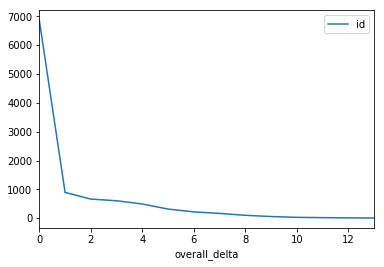

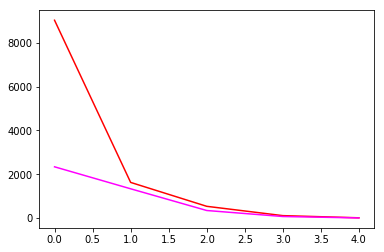

Важность свойств в порядке убывания важности:

In [35]:
w_features = copy.copy(clf_features)
for i in range(len(clf_features)):
    w_features[i] = (fitted_clf_gbr.feature_importances_[i], clf_features[i])
w_features = sorted(w_features)
for i in range(len(w_features) - 1, -1, -1):
    print(w_features[i])

(0.23257668902303283, 'w4_played')
(0.060645126237111976, 'lensess_w4_meandmax')
(0.038379329278801048, 'pgr_w4_mean')
(0.03642224883051081, 'pgr_w4_meandmax')
(0.029605292732231808, 'lensess_w4_mean')
(0.02949142064140443, 'lensess_w3_mean')
(0.02807181586987877, 'w3_played')
(0.027042689391797849, 'quest_w4_mean')
(0.026030783548216512, 'sess_w3_mean')
(0.026011729109218375, 'sess_w4_mean')
(0.023382559207382032, 'quest_w4_meandmax')
(0.023190772042011441, 'lensess_w1_meandmax')
(0.020848463229956534, 'lensess_w2_mean')
(0.020806865130015523, 'lensess_w3_meandmax')
(0.02076880433499903, 'clusters_w1_mean')
(0.018859804928288652, 'lensess_w2_meandmax')
(0.018237245840745486, 'clusters_w4_mean')
(0.017419429506068368, 'm_quests_w3_mean')
(0.016521174246234557, 'pgr_w3_mean')
(0.016493022916095557, 'sess_w4_meandmax')
(0.01413115692774191, 'sess_w2_meandmax')
(0.014121706609500346, 'lensess_w1_mean')
(0.014021934443081792, 'sess_w1_mean')
(0.012945231559509818, 'm_quests_w4_mean')
(0.01

Можно посмотреть соотношение количества TP, TN, FP, FN:

In [38]:
print(metrics.confusion_matrix(dau_pact_table[threshold:]['is_active'], dau_pact_table[threshold:]['predict_active']))

[[25525  4500]
 [ 6365 22883]]
